# [Particle aggregation](@id Aggregation)

In [1]:
using CellBasedModels
using GLMakie
GLMakie.inline!(true)

In [2]:
model = Agent(2,

    localFloatInteraction = [:fx,:fy],

    globalFloat = [:rRep,:fRep,:rAtr,:fAtr,:D],

    updateInteraction = quote
        d = euclideanDistance(x.i,x.j,y.i,y.j)
        dx = (x.i-x.j)/d
        dy = (y.i-y.j)/d
        if d < rRep #Repulsion forces
            fx.i += fRep*(rRep-d)*dx  
            fy.i += fRep*(rRep-d)*dy  
        elseif d < rAtr #Attraction forces
            fx.i += -fAtr*(rAtr-d)*dx  
            fy.i += -fAtr*(rAtr-d)*dy  
        end
    end,

    updateVariable = quote
        #Bounaries
        if x < simBox[1,1]+rRep/2
            fx += fRep
        elseif x > simBox[1,2]-rRep/2
            fx -= fRep        
        end
        if y < simBox[2,1]+rRep/2
            fy += fRep
        elseif y > simBox[2,2]-rRep/2
            fy -= fRep
        end
        #Dynamics
        d( x ) = dt( fx ) + dW( D )
        d( y ) = dt( fy ) + dW( D )
    end,
    
    integrator=:Heun
);

## Test Attraction

In [3]:
simBox = [-5. 5; -2 2]
com = Community(model,N=[2],
        rRep=.8,
        fRep=1,
        rAtr=1.,
        fAtr=1.,
        x=[-.1,.1],
        y=[0.,0.],
        dt=[.1],
        simBox = simBox
        );

In [4]:
evolve!(com,steps=50,saveCurrentState=true)

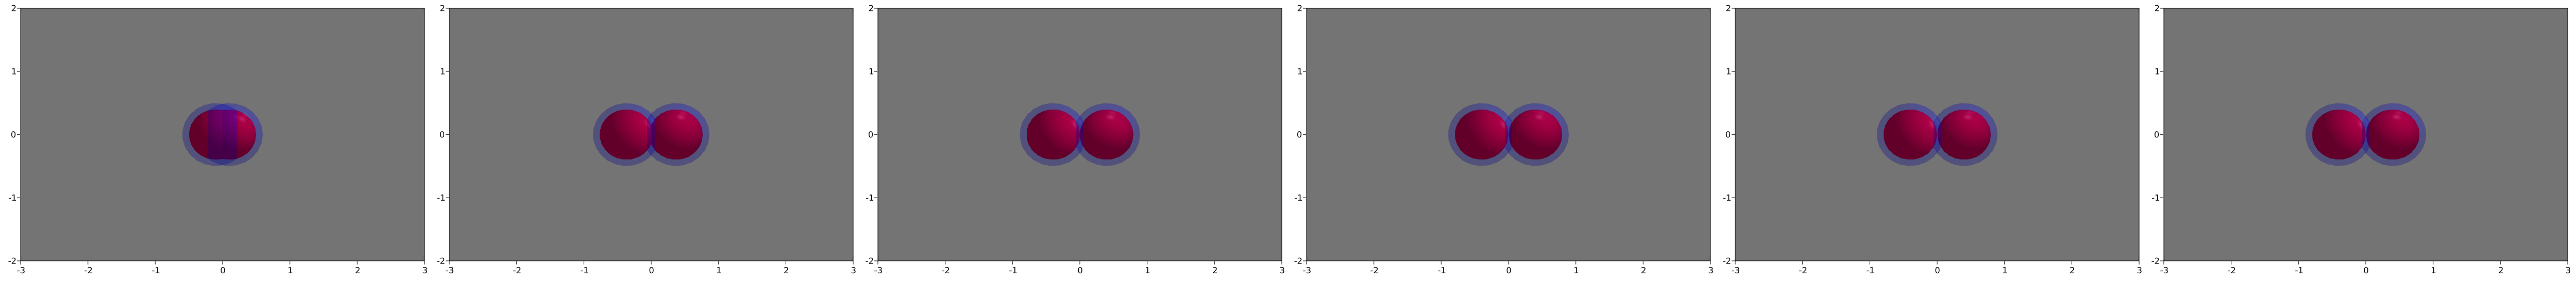

In [5]:
d = getParameter(com,[:x,:y])

fig = Figure(resolution=(5000,550))

for (i,time) in enumerate(1:round(Int64,length(com)/5):length(com))
    ax = Axis(fig[1,i])
    mesh!(ax, [simBox[1,1] simBox[2,1];simBox[1,1] simBox[2,2];simBox[1,2] simBox[2,2];simBox[1,2] simBox[2,1]], [1 2 4; 2 3 4], color=:lightgrey)
    meshscatter!(ax,d[:x][time],d[:y][time],markersize=com[:rAtr][1]/2,color=(:blue,.3),transparency=true)
    meshscatter!(ax,d[:x][time],d[:y][time],markersize=com[:rRep][1]/2,color=:red)
    xlims!(ax,-3,3)
    ylims!(ax,-2,2)
end

fig

## Test boundaries

In [6]:
simBox = [-5. 5; -2 2]
com = Community(model,N=[1],
        rRep=.8,
        fRep=1,
        rAtr=1.,
        fAtr=1.,
        x=[0.],
        y=[-2.5],
        dt=[.1],
        simBox = simBox
        );

In [7]:
evolve!(com,steps=20,saveCurrentState=true)

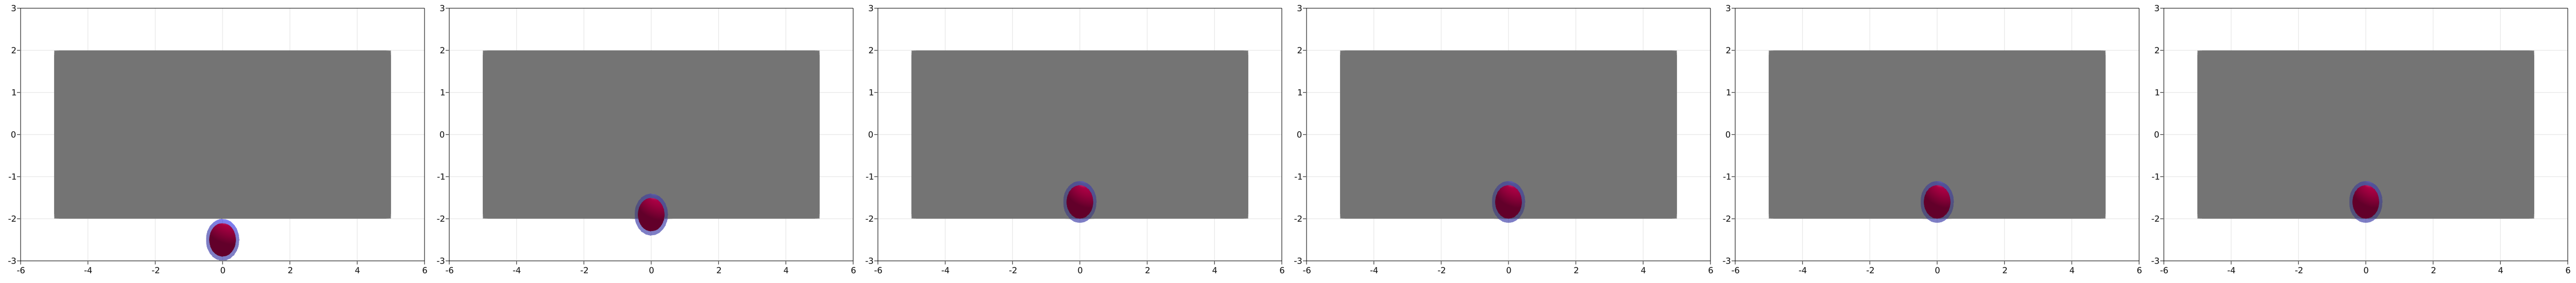

In [8]:
d = getParameter(com,[:x,:y])

fig = Figure(resolution=(5000,500))

for (i,time) in enumerate(1:round(Int64,length(com)/5):length(com))
    ax = Axis(fig[1,i])
    mesh!(ax, [simBox[1,1] simBox[2,1];simBox[1,1] simBox[2,2];simBox[1,2] simBox[2,2];simBox[1,2] simBox[2,1]], [1 2 4; 2 3 4], color=:lightgrey)
    meshscatter!(ax,d[:x][time],d[:y][time],markersize=com[:rAtr][1]/2,color=(:blue,.3),transparency=true)
    meshscatter!(ax,d[:x][time],d[:y][time],markersize=com[:rRep][1]/2,color=:red)
    xlims!(ax,-6,6)
    ylims!(ax,-3,3)
end

fig

# Add noise

In [27]:
model2 = Agent(2,

    localFloatInteraction = [:fx,:fy],

    globalFloat = [:rRep,:fRep,:rAtr,:fAtr,:D],

    updateInteraction = quote
        d = euclideanDistance(x.i,x.j,y.i,y.j)
        dx = (x.i-x.j)/d
        dy = (y.i-y.j)/d
        if d < rRep #Repulsion forces
            fx.i += fRep*(rRep-d)*dx  
            fy.i += fRep*(rRep-d)*dy  
        elseif d < rAtr #Attraction forces
            fx.i += -fAtr*(rAtr-d)*dx  
            fy.i += -fAtr*(rAtr-d)*dy  
        end
    end,

    updateVariable = quote
        #Bounaries
        if x < simBox[1,1]+rRep/2
            fx += fRep
        elseif x > simBox[1,2]-rRep/2
            fx -= fRep        
        end
        if y < simBox[2,1]+rRep/2
            fy += fRep
        elseif y > simBox[2,2]-rRep/2
            fy -= fRep
        end
        #Dynamics
        d( x ) = dt( fx ) + dW( D )
        d( y ) = dt( fy ) + dW( D )
    end,

    updateGlobal= quote
        if t < 100
            fAtr = 0.
        elseif t > 100 && t < 400
            fAtr = 2.
        else
            fAtr = 0.
        end
    end,

    integrator=:Heun
);

In [22]:
simBox = [-10. 10; -10 10]
N = 100
com = Community(model,N=[N],
        rRep=.8,
        fRep=1,
        rAtr=1.,
        fAtr=2.,
        x = 20 .*rand(N) .-10,
        y = 20 .*rand(N) .-10,
        dt=[.1],
        D=[.1],
        simBox = simBox
        );

In [23]:
evolve!(com,steps=6000,saveEach=20,saveCurrentState=true)

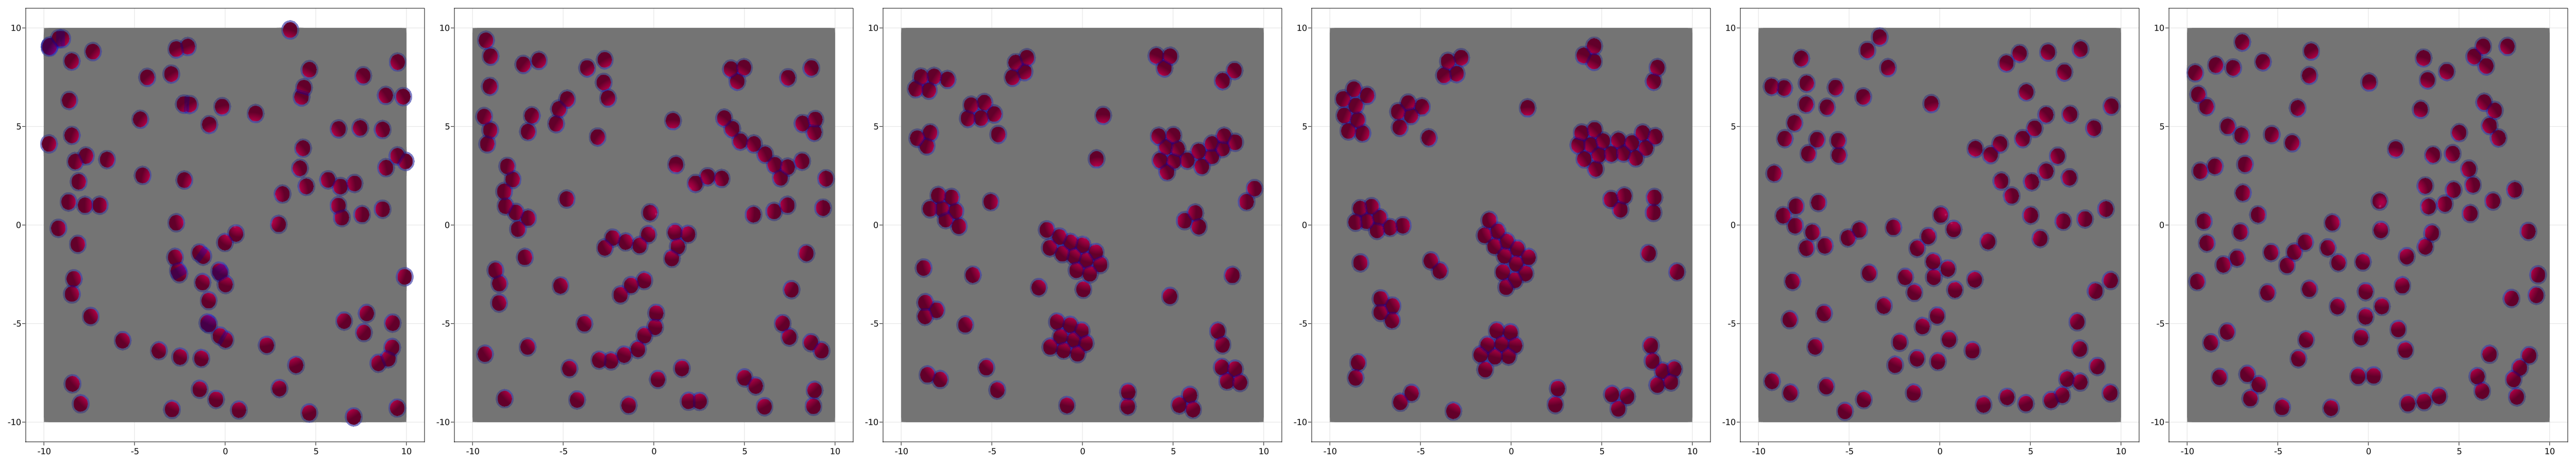

In [24]:
d = getParameter(com,[:x,:y])

fig = Figure(resolution=(5000,900))

for (i,time) in enumerate(1:round(Int64,length(com)/5):length(com))
    ax = Axis(fig[1,i])
    mesh!(ax, [simBox[1,1] simBox[2,1];simBox[1,1] simBox[2,2];simBox[1,2] simBox[2,2];simBox[1,2] simBox[2,1]], [1 2 4; 2 3 4], color=:lightgrey)
    meshscatter!(ax,d[:x][time],d[:y][time],markersize=com[:rAtr][1]/2,color=(:blue,.3),transparency=true)
    meshscatter!(ax,d[:x][time],d[:y][time],markersize=com[:rRep][1]/2,color=:red)
    xlims!(ax,(simBox[1,:].+[-1,1])...)
    ylims!(ax,(simBox[2,:].+[-1,1])...)
    # lines!(ax,[i[1] for i in d[:x]],[i[1] for i in d[:y]])
end

fig

In [26]:
d = getParameter(com,[:x,:y,:fAtr])
colorMap = Dict(1=>:blue,2=>:orange,3=>:green)
for (i,time) in enumerate(1:length(com))
    fig = Figure(resolution=(2000,2000))
    ax = Axis(fig[1,1],title=string("Adhesion: ",d[:fAtr][time][1]),titlesize=70)
    mesh!(ax, [simBox[1,1] simBox[2,1];simBox[1,1] simBox[2,2];simBox[1,2] simBox[2,2];simBox[1,2] simBox[2,1]], [1 2 4; 2 3 4], color=:lightgrey)
    meshscatter!(ax,d[:x][time],d[:y][time],markersize=com[:rAtr][1]/2,color=(:blue,.3),transparency=true)
    meshscatter!(ax,d[:x][time],d[:y][time],markersize=com[:rRep][1]/2,color=:red)
    xlims!(ax,(simBox[1,:].+[-1,1])...)
    ylims!(ax,(simBox[2,:].+[-1,1])...)

    ind = "000$i"
    save("video/Coalescence$(ind[end-2:end]).jpeg",fig)
end

## Neighbors

In [2]:
model = Agent(2,

    localFloatInteraction = [:fx,:fy],

    globalFloat = [:rRep,:fRep,:rAtr,:fAtr,:D],

    updateInteraction = quote
        d = euclideanDistance(x.i,x.j,y.i,y.j)
        dx = (x.i-x.j)/d
        dy = (y.i-y.j)/d
        if d < rRep #Repulsion forces
            fx.i += fRep*(rRep-d)*dx  
            fy.i += fRep*(rRep-d)*dy  
        elseif d < rAtr #Attraction forces
            fx.i += -fAtr*(rAtr-d)*dx  
            fy.i += -fAtr*(rAtr-d)*dy  
        end
    end,

    updateVariable = quote
        #Bounaries
        if x < simBox[1,1]+rRep/2
            fx += fRep
        elseif x > simBox[1,2]-rRep/2
            fx -= fRep        
        end
        if y < simBox[2,1]+rRep/2
            fy += fRep
        elseif y > simBox[2,2]-rRep/2
            fy -= fRep
        end
        #Dynamics
        d( x ) = dt( fx ) + dW( D )
        d( y ) = dt( fy ) + dW( D )
    end,
    
    integrator=:Heun
);

In [27]:
modelFull = Agent(2,
    baseModelInit = [model],
    integrator = :Heun,
    neighbors = :Full
);
modelVerlet = Agent(2,
    baseModelInit = [model],
    integrator = :Heun,
    neighbors = :VerletDisplacement
);
modelCellLinked = Agent(2,
    baseModelInit = [model],
    integrator = :Heun,
    neighbors = :CellLinked
);

In [36]:
function initialize(model,N,simBox)
        return Community(model,N=[N],
                simBox = simBox,
                nMaxNeighbors = [100],
                skin = [4.],
                cellEdge = [2.,2.],
                
                rRep=.8,
                fRep=1,
                rAtr=1.,
                fAtr=1.,
                D = .5,
                x=rand(N).*(simBox[1,2]-simBox[1,1]).+simBox[1,1],
                y=rand(N).*(simBox[2,2]-simBox[2,1]).+simBox[2,1],
                dt=[.1],
                );
end;

In [41]:
ρ=.1
S = 1

N = []
tFull = []
tVerlet = []
tCellLinked = []
for S in 1:.5:7
    simBox = S.*[-10. 10; -10 10]
    n = round(Int64,ρ*(simBox[1,2]-simBox[1,1])*(simBox[2,2]-simBox[2,1]))
    push!(N,n)

    com = initialize(modelFull,n,simBox);
    t = @elapsed evolve!(com,steps=1000,saveEach=10,saveCurrentState=true)
    push!(tFull,t)

    com = initialize(modelVerlet,n,simBox);
    t = @elapsed evolve!(com,steps=1000,saveEach=10,saveCurrentState=true)
    push!(tVerlet,t)

    com = initialize(modelCellLinked,n,simBox);
    t = @elapsed evolve!(com,steps=1000,saveEach=10,saveCurrentState=true)
    push!(tCellLinked,t)
end

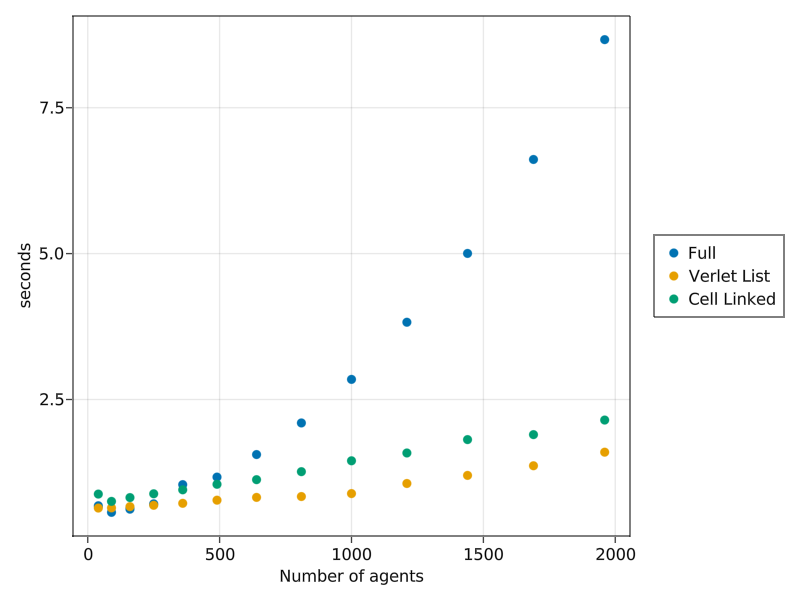

In [54]:
fig = Figure(resolution=(800,600))
ax = Axis(fig[1,1],xlabel="Number of agents",ylabel="seconds")

l1 = scatter!(ax,Float64.(N),Float64.(tFull))
l2 = scatter!(ax,Float64.(N),Float64.(tVerlet))
l3 = scatter!(ax,Float64.(N),Float64.(tCellLinked))
Legend(fig[1,2],[l1,l2,l3],["Full","Verlet List","Cell Linked"])

fig

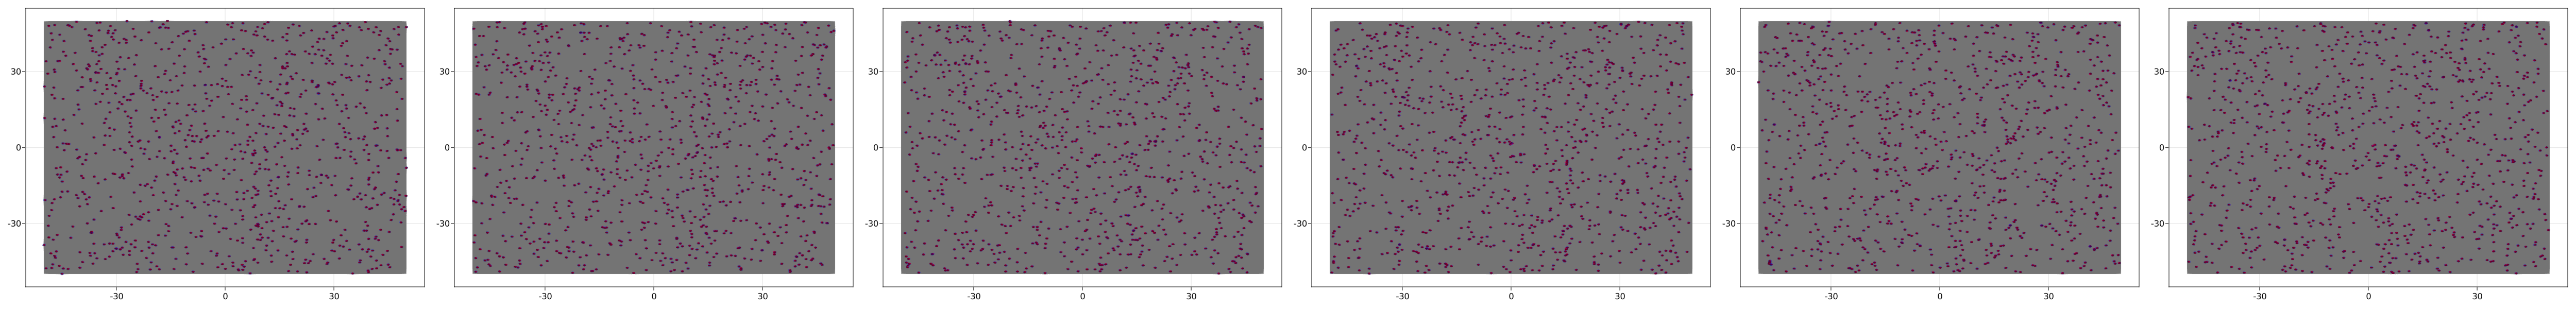

In [40]:
d = getParameter(com,[:x,:y])

fig = Figure(resolution=(5000,600))

for (i,time) in enumerate(1:round(Int64,length(com)/5):length(com))
    ax = Axis(fig[1,i])
    mesh!(ax, [simBox[1,1] simBox[2,1];simBox[1,1] simBox[2,2];simBox[1,2] simBox[2,2];simBox[1,2] simBox[2,1]], [1 2 4; 2 3 4], color=:lightgrey)
    meshscatter!(ax,d[:x][time],d[:y][time],markersize=com[:rAtr][1]/2,color=(:blue,.3),transparency=true)
    meshscatter!(ax,d[:x][time],d[:y][time],markersize=com[:rRep][1]/2,color=:red)
    xlims!(ax,(simBox[1,:].*1.1)...)
    ylims!(ax,(simBox[2,:].*1.1)...)
end

fig